# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is straightforward to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks.

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/backprop_diagram.png' width=550px>

In the forward pass through the network, our data and operations go from bottom to top here. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$. Finally we calculate the loss $\ell$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propagate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Note:** I'm glossing over a few details here that require some knowledge of vector calculus, but they aren't necessary to understand what's going on.

We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Note
If you haven't seen `nn.Sequential` yet, please finish the end of the Part 2 notebook.

In [3]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2815, grad_fn=<NllLossBackward>)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.

In [4]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=-1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logps = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.3398, grad_fn=<NllLossBackward>)


## Autograd

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [5]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.3721, -0.8721],
        [-1.2336,  0.5714]], requires_grad=True)


In [6]:
y = x**2
print(y)

tensor([[0.1384, 0.7605],
        [1.5219, 0.3265]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [7]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [8]:
z = y.mean()
print(z)

tensor(0.6868, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [9]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [10]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.1860, -0.4360],
        [-0.6168,  0.2857]])
tensor([[ 0.1860, -0.4360],
        [-0.6168,  0.2857]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the cost with respect to the weights. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [11]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [12]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0024,  0.0024,  0.0024,  ...,  0.0024,  0.0024,  0.0024],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014]])


## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [13]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [14]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0211, -0.0086, -0.0078,  ..., -0.0277,  0.0145,  0.0037],
        [-0.0161, -0.0117,  0.0332,  ..., -0.0315, -0.0115,  0.0056],
        [ 0.0100,  0.0158, -0.0294,  ..., -0.0297, -0.0012,  0.0143],
        ...,
        [-0.0249, -0.0024, -0.0317,  ..., -0.0208,  0.0237, -0.0336],
        [ 0.0273, -0.0012, -0.0032,  ..., -0.0283, -0.0109, -0.0318],
        [ 0.0024,  0.0066, -0.0313,  ..., -0.0026, -0.0328, -0.0269]],
       requires_grad=True)
Gradient - tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0045, -0.0045, -0.0045,  ..., -0.0045, -0.0045, -0.0045],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010]])


In [15]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0211, -0.0086, -0.0078,  ..., -0.0277,  0.0145,  0.0037],
        [-0.0161, -0.0117,  0.0332,  ..., -0.0315, -0.0115,  0.0056],
        [ 0.0100,  0.0159, -0.0294,  ..., -0.0296, -0.0011,  0.0144],
        ...,
        [-0.0249, -0.0024, -0.0317,  ..., -0.0208,  0.0237, -0.0336],
        [ 0.0273, -0.0012, -0.0031,  ..., -0.0282, -0.0109, -0.0317],
        [ 0.0024,  0.0066, -0.0313,  ..., -0.0026, -0.0328, -0.0269]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [16]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        print(images.size())
        # TODO: Training pass
        optimizer.zero_grad()
        output=model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(running_loss)
    else:
        print(len(trainloader))
        print(f"Training loss: {running_loss/len(trainloader)}")

torch.Size([64, 784])
2.2998557090759277
torch.Size([64, 784])
4.598760604858398
torch.Size([64, 784])
6.912074089050293
torch.Size([64, 784])
9.219568014144897
torch.Size([64, 784])
11.52581262588501
torch.Size([64, 784])
13.822996139526367
torch.Size([64, 784])
16.123191833496094
torch.Size([64, 784])
18.427517652511597
torch.Size([64, 784])
20.737731456756592
torch.Size([64, 784])
23.022813081741333
torch.Size([64, 784])
25.31328010559082
torch.Size([64, 784])
27.601129293441772
torch.Size([64, 784])
29.890857934951782
torch.Size([64, 784])
32.17146420478821
torch.Size([64, 784])
34.45475888252258
torch.Size([64, 784])
36.728286027908325
torch.Size([64, 784])
38.995328426361084
torch.Size([64, 784])
41.282126665115356
torch.Size([64, 784])
43.56417632102966
torch.Size([64, 784])
45.84182405471802
torch.Size([64, 784])
48.12418031692505
torch.Size([64, 784])
50.40329313278198
torch.Size([64, 784])
52.68925142288208
torch.Size([64, 784])
54.9611611366272
torch.Size([64, 784])
57.22083

torch.Size([64, 784])
432.07634460926056
torch.Size([64, 784])
433.89179837703705
torch.Size([64, 784])
435.5752921104431
torch.Size([64, 784])
437.3039833307266
torch.Size([64, 784])
439.0597091913223
torch.Size([64, 784])
440.77869606018066
torch.Size([64, 784])
442.46697866916656
torch.Size([64, 784])
444.26225912570953
torch.Size([64, 784])
445.9610034227371
torch.Size([64, 784])
447.67360067367554
torch.Size([64, 784])
449.4604218006134
torch.Size([64, 784])
451.1971251964569
torch.Size([64, 784])
452.79224014282227
torch.Size([64, 784])
454.531450510025
torch.Size([64, 784])
456.2069882154465
torch.Size([64, 784])
457.95287120342255
torch.Size([64, 784])
459.66556537151337
torch.Size([64, 784])
461.37475633621216
torch.Size([64, 784])
463.0572866201401
torch.Size([64, 784])
464.755095243454
torch.Size([64, 784])
466.4547168016434
torch.Size([64, 784])
468.1040518283844
torch.Size([64, 784])
469.7795914411545
torch.Size([64, 784])
471.43311405181885
torch.Size([64, 784])
473.11936

torch.Size([64, 784])
695.639687359333
torch.Size([64, 784])
696.399684548378
torch.Size([64, 784])
697.2942097783089
torch.Size([64, 784])
698.1121550798416
torch.Size([64, 784])
698.745929479599
torch.Size([64, 784])
699.6722231507301
torch.Size([64, 784])
700.4879856109619
torch.Size([64, 784])
701.3953475952148
torch.Size([64, 784])
702.1756238341331
torch.Size([64, 784])
703.0517517328262
torch.Size([64, 784])
703.926207959652
torch.Size([64, 784])
704.703881919384
torch.Size([64, 784])
705.5452501177788
torch.Size([64, 784])
706.4134722352028
torch.Size([64, 784])
707.289276778698
torch.Size([64, 784])
708.0439713597298
torch.Size([64, 784])
708.8844052553177
torch.Size([64, 784])
709.7761244177818
torch.Size([64, 784])
710.4387025237083
torch.Size([64, 784])
711.2281558513641
torch.Size([64, 784])
711.980783700943
torch.Size([64, 784])
712.9063736200333
torch.Size([64, 784])
713.7412937283516
torch.Size([64, 784])
714.5702372789383
torch.Size([64, 784])
715.3183891177177
torch.S

torch.Size([64, 784])
836.5204414129257
torch.Size([64, 784])
837.1534070968628
torch.Size([64, 784])
837.6711845397949
torch.Size([64, 784])
838.1301899552345
torch.Size([64, 784])
838.6115317940712
torch.Size([64, 784])
839.0771886706352
torch.Size([64, 784])
839.6940417289734
torch.Size([64, 784])
840.2756240367889
torch.Size([64, 784])
840.7347039580345
torch.Size([64, 784])
841.2349481582642
torch.Size([64, 784])
841.676792383194
torch.Size([64, 784])
842.2940412163734
torch.Size([64, 784])
842.866762816906
torch.Size([64, 784])
843.5494294762611
torch.Size([64, 784])
844.156845331192
torch.Size([64, 784])
844.6982432603836
torch.Size([64, 784])
845.3139446377754
torch.Size([64, 784])
845.9018364548683
torch.Size([64, 784])
846.4177489280701
torch.Size([64, 784])
846.8948476016521
torch.Size([64, 784])
847.4917249381542
torch.Size([64, 784])
848.0478608310223
torch.Size([64, 784])
848.5150509476662
torch.Size([64, 784])
849.1032592058182
torch.Size([64, 784])
849.6782438158989
tor

torch.Size([64, 784])
945.0538295507431
torch.Size([64, 784])
945.4624336361885
torch.Size([64, 784])
946.0374079942703
torch.Size([64, 784])
946.480430752039
torch.Size([64, 784])
946.9583596289158
torch.Size([64, 784])
947.4531211256981
torch.Size([64, 784])
947.8330021202564
torch.Size([64, 784])
948.1563139855862
torch.Size([64, 784])
948.5565231442451
torch.Size([64, 784])
949.1144806146622
torch.Size([64, 784])
949.4062397778034
torch.Size([64, 784])
949.7642138302326
torch.Size([64, 784])
950.1029902100563
torch.Size([64, 784])
950.6510065197945
torch.Size([64, 784])
951.1649461984634
torch.Size([64, 784])
951.5865093171597
torch.Size([64, 784])
951.9174056351185
torch.Size([64, 784])
952.4270069897175
torch.Size([64, 784])
953.0563651025295
torch.Size([64, 784])
953.608270317316
torch.Size([64, 784])
954.0861622989178
torch.Size([64, 784])
954.5427884459496
torch.Size([64, 784])
954.9773041903973
torch.Size([64, 784])
955.5208020508289
torch.Size([64, 784])
956.0488703548908
to

45.86387011408806
torch.Size([64, 784])
46.248823672533035
torch.Size([64, 784])
46.81422999501228
torch.Size([64, 784])
47.39285400509834
torch.Size([64, 784])
47.863727539777756
torch.Size([64, 784])
48.24728238582611
torch.Size([64, 784])
48.653094440698624
torch.Size([64, 784])
49.05195650458336
torch.Size([64, 784])
49.3055300116539
torch.Size([64, 784])
49.73907509446144
torch.Size([64, 784])
50.05254063010216
torch.Size([64, 784])
50.476321429014206
torch.Size([64, 784])
50.696294873952866
torch.Size([64, 784])
51.11684212088585
torch.Size([64, 784])
51.575029730796814
torch.Size([64, 784])
51.81065499782562
torch.Size([64, 784])
52.30427128076553
torch.Size([64, 784])
52.6052628159523
torch.Size([64, 784])
53.10304117202759
torch.Size([64, 784])
53.45156216621399
torch.Size([64, 784])
54.061466455459595
torch.Size([64, 784])
54.48501980304718
torch.Size([64, 784])
55.09090602397919
torch.Size([64, 784])
55.53625947237015
torch.Size([64, 784])
56.057108879089355
torch.Size([64, 

torch.Size([64, 784])
133.6526169925928
torch.Size([64, 784])
134.1515329927206
torch.Size([64, 784])
134.5736631602049
torch.Size([64, 784])
134.96086286008358
torch.Size([64, 784])
135.38389520347118
torch.Size([64, 784])
135.9094835370779
torch.Size([64, 784])
136.2723400145769
torch.Size([64, 784])
136.61046548187733
torch.Size([64, 784])
137.02452518045902
torch.Size([64, 784])
137.31941525638103
torch.Size([64, 784])
137.6442481726408
torch.Size([64, 784])
138.1421607285738
torch.Size([64, 784])
138.5158009082079
torch.Size([64, 784])
138.931122854352
torch.Size([64, 784])
139.5041415244341
torch.Size([64, 784])
139.89251743257046
torch.Size([64, 784])
140.198667421937
torch.Size([64, 784])
140.52917321026325
torch.Size([64, 784])
140.92465536296368
torch.Size([64, 784])
141.08670938014984
torch.Size([64, 784])
141.41307839751244
torch.Size([64, 784])
141.7813917696476
torch.Size([64, 784])
142.11355996131897
torch.Size([64, 784])
142.35299235582352
torch.Size([64, 784])
142.7270

torch.Size([64, 784])
214.3456188738346
torch.Size([64, 784])
214.79064920544624
torch.Size([64, 784])
215.02974167466164
torch.Size([64, 784])
215.3144914805889
torch.Size([64, 784])
215.70718410611153
torch.Size([64, 784])
215.91574847698212
torch.Size([64, 784])
216.15701194107533
torch.Size([64, 784])
216.5645222812891
torch.Size([64, 784])
216.82207979261875
torch.Size([64, 784])
217.06497710943222
torch.Size([64, 784])
217.5250245630741
torch.Size([64, 784])
218.0128919184208
torch.Size([64, 784])
218.31456312537193
torch.Size([64, 784])
218.5777783691883
torch.Size([64, 784])
218.96035996079445
torch.Size([64, 784])
219.23837581276894
torch.Size([64, 784])
219.71603953838348
torch.Size([64, 784])
220.09874173998833
torch.Size([64, 784])
220.5867484509945
torch.Size([64, 784])
221.02689191699028
torch.Size([64, 784])
221.32149800658226
torch.Size([64, 784])
221.77735325694084
torch.Size([64, 784])
222.19551864266396
torch.Size([64, 784])
222.58989971876144
torch.Size([64, 784])
2

287.9884258508682
torch.Size([64, 784])
288.29133147001266
torch.Size([64, 784])
288.5366911441088
torch.Size([64, 784])
288.77283738553524
torch.Size([64, 784])
289.2721986323595
torch.Size([64, 784])
289.6744610220194
torch.Size([64, 784])
289.9565736204386
torch.Size([64, 784])
290.2339438945055
torch.Size([64, 784])
290.48264364898205
torch.Size([64, 784])
290.8514501005411
torch.Size([64, 784])
291.09296648204327
torch.Size([64, 784])
291.5267009884119
torch.Size([64, 784])
291.83945743739605
torch.Size([64, 784])
292.2024751752615
torch.Size([64, 784])
292.66056875884533
torch.Size([64, 784])
292.99370186030865
torch.Size([64, 784])
293.2527284473181
torch.Size([64, 784])
293.54060788452625
torch.Size([64, 784])
293.948076620698
torch.Size([64, 784])
294.25537253916264
torch.Size([64, 784])
294.7222767621279
torch.Size([64, 784])
295.14471776783466
torch.Size([64, 784])
295.4657930880785
torch.Size([64, 784])
295.87181071937084
torch.Size([64, 784])
296.26193641126156
torch.Size(

torch.Size([64, 784])
3.7529405653476715
torch.Size([64, 784])
3.9890493601560593
torch.Size([64, 784])
4.463728591799736
torch.Size([64, 784])
4.8937864154577255
torch.Size([64, 784])
5.132544860243797
torch.Size([64, 784])
5.398095354437828
torch.Size([64, 784])
5.645426735281944
torch.Size([64, 784])
5.931931301951408
torch.Size([64, 784])
6.184298560023308
torch.Size([64, 784])
6.3606962114572525
torch.Size([64, 784])
6.566435784101486
torch.Size([64, 784])
6.97824826836586
torch.Size([64, 784])
7.417411237955093
torch.Size([64, 784])
7.705498218536377
torch.Size([64, 784])
7.990151762962341
torch.Size([64, 784])
8.391992509365082
torch.Size([64, 784])
8.64097885787487
torch.Size([64, 784])
8.860595896840096
torch.Size([64, 784])
9.138064846396446
torch.Size([64, 784])
9.411982581019402
torch.Size([64, 784])
9.78830237686634
torch.Size([64, 784])
10.128509148955345
torch.Size([64, 784])
10.513867601752281
torch.Size([64, 784])
10.726507157087326
torch.Size([64, 784])
11.24162134528

torch.Size([64, 784])
75.1326270699501
torch.Size([64, 784])
75.48691210150719
torch.Size([64, 784])
75.82963535189629
torch.Size([64, 784])
76.07036373019218
torch.Size([64, 784])
76.32070055603981
torch.Size([64, 784])
76.73592415452003
torch.Size([64, 784])
76.93722818791866
torch.Size([64, 784])
77.4613217562437
torch.Size([64, 784])
77.89564596116543
torch.Size([64, 784])
78.26951323449612
torch.Size([64, 784])
78.51785276830196
torch.Size([64, 784])
78.86086617410183
torch.Size([64, 784])
79.22781939804554
torch.Size([64, 784])
79.45923326909542
torch.Size([64, 784])
79.70891480147839
torch.Size([64, 784])
80.12876896560192
torch.Size([64, 784])
80.43069778382778
torch.Size([64, 784])
81.04690407216549
torch.Size([64, 784])
81.34529702365398
torch.Size([64, 784])
81.73532618582249
torch.Size([64, 784])
82.13654287159443
torch.Size([64, 784])
82.40199460089207
torch.Size([64, 784])
82.74687702953815
torch.Size([64, 784])
83.08085684478283
torch.Size([64, 784])
83.48331208527088
to

torch.Size([64, 784])
143.97701279819012
torch.Size([64, 784])
144.22490234673023
torch.Size([64, 784])
144.3828981667757
torch.Size([64, 784])
144.52492874860764
torch.Size([64, 784])
145.07624888420105
torch.Size([64, 784])
145.44580006599426
torch.Size([64, 784])
145.85813361406326
torch.Size([64, 784])
146.11567968130112
torch.Size([64, 784])
146.54485395550728
torch.Size([64, 784])
146.92737731337547
torch.Size([64, 784])
147.17923471331596
torch.Size([64, 784])
147.51901957392693
torch.Size([64, 784])
147.89849695563316
torch.Size([64, 784])
148.28734824061394
torch.Size([64, 784])
148.63883742690086
torch.Size([64, 784])
149.06604918837547
torch.Size([64, 784])
149.2985160946846
torch.Size([64, 784])
149.66609251499176
torch.Size([64, 784])
150.07423356175423
torch.Size([64, 784])
150.34848794341087
torch.Size([64, 784])
150.77066722512245
torch.Size([64, 784])
150.96490982174873
torch.Size([64, 784])
151.46188893914223
torch.Size([64, 784])
151.78636145591736
torch.Size([64, 78

torch.Size([64, 784])
208.568010404706
torch.Size([64, 784])
208.81031404435635
torch.Size([64, 784])
209.35472010076046
torch.Size([64, 784])
209.5808570086956
torch.Size([64, 784])
209.87798091769218
torch.Size([64, 784])
210.1337746679783
torch.Size([64, 784])
210.47949966788292
torch.Size([64, 784])
210.84614276885986
torch.Size([64, 784])
211.09599114954472
torch.Size([64, 784])
211.29171220958233
torch.Size([64, 784])
211.6110475808382
torch.Size([64, 784])
212.01284082233906
torch.Size([64, 784])
212.26052796840668
torch.Size([64, 784])
212.50604978203773
torch.Size([64, 784])
212.65836136043072
torch.Size([64, 784])
212.91177229583263
torch.Size([64, 784])
213.24490766227245
torch.Size([64, 784])
213.62251774966717
torch.Size([64, 784])
213.87419037520885
torch.Size([64, 784])
214.31227572262287
torch.Size([64, 784])
214.63605476915836
torch.Size([64, 784])
214.88135984539986
torch.Size([64, 784])
215.4694677889347
torch.Size([64, 784])
215.9090955555439
torch.Size([64, 784])
2

torch.Size([64, 784])
273.9742386713624
torch.Size([64, 784])
274.2378452196717
torch.Size([64, 784])
274.5484969392419
torch.Size([64, 784])
274.82488936930895
torch.Size([64, 784])
275.13338143378496
torch.Size([64, 784])
275.41698402911425
torch.Size([64, 784])
275.5876332297921
torch.Size([64, 784])
275.7858621403575
torch.Size([64, 784])
276.24434124678373
torch.Size([64, 784])
276.7528069540858
torch.Size([64, 784])
277.01029186695814
torch.Size([64, 784])
277.25255819410086
torch.Size([64, 784])
277.67982252687216
torch.Size([64, 784])
278.2269443497062
torch.Size([64, 784])
278.6295737847686
torch.Size([64, 784])
279.0748116597533
torch.Size([64, 784])
279.36995642632246
torch.Size([64, 784])
279.6929589435458
torch.Size([64, 784])
279.84194166213274
torch.Size([64, 784])
280.00199691206217
torch.Size([64, 784])
280.2515825405717
torch.Size([64, 784])
280.4753574356437
torch.Size([64, 784])
280.61056784540415
torch.Size([64, 784])
280.7814824655652
torch.Size([64, 784])
281.153

torch.Size([64, 784])
31.284861229360104
torch.Size([64, 784])
31.637210093438625
torch.Size([64, 784])
31.876644544303417
torch.Size([64, 784])
32.22160654515028
torch.Size([64, 784])
32.52844773977995
torch.Size([64, 784])
32.907371394336224
torch.Size([64, 784])
33.26053171604872
torch.Size([64, 784])
33.4834403321147
torch.Size([64, 784])
33.819968692958355
torch.Size([64, 784])
34.107912711799145
torch.Size([64, 784])
34.33069694787264
torch.Size([64, 784])
34.58324880152941
torch.Size([64, 784])
34.904194600880146
torch.Size([64, 784])
35.159165658056736
torch.Size([64, 784])
35.543930269777775
torch.Size([64, 784])
35.75871578603983
torch.Size([64, 784])
36.16547606140375
torch.Size([64, 784])
36.49912700802088
torch.Size([64, 784])
36.72604066878557
torch.Size([64, 784])
36.977126486599445
torch.Size([64, 784])
37.30327642709017
torch.Size([64, 784])
37.68901041895151
torch.Size([64, 784])
37.9945308342576
torch.Size([64, 784])
38.2868170812726
torch.Size([64, 784])
38.56406608

torch.Size([64, 784])
93.32912454754114
torch.Size([64, 784])
93.55228809267282
torch.Size([64, 784])
93.9815559759736
torch.Size([64, 784])
94.3337388113141
torch.Size([64, 784])
94.62951502949
torch.Size([64, 784])
94.85271779447794
torch.Size([64, 784])
95.09400302916765
torch.Size([64, 784])
95.334811873734
torch.Size([64, 784])
95.51292862743139
torch.Size([64, 784])
95.77673848718405
torch.Size([64, 784])
96.03918864578009
torch.Size([64, 784])
96.23856230825186
torch.Size([64, 784])
96.5553474649787
torch.Size([64, 784])
96.84607499092817
torch.Size([64, 784])
97.24715434759855
torch.Size([64, 784])
97.44014037400484
torch.Size([64, 784])
97.66868465393782
torch.Size([64, 784])
98.06639041751623
torch.Size([64, 784])
98.4755414351821
torch.Size([64, 784])
99.06404676288366
torch.Size([64, 784])
99.3160630390048
torch.Size([64, 784])
99.6582004353404
torch.Size([64, 784])
99.86549123376608
torch.Size([64, 784])
100.2345614656806
torch.Size([64, 784])
100.6106897816062
torch.Size(

torch.Size([64, 784])
152.6354046240449
torch.Size([64, 784])
152.93733356148005
torch.Size([64, 784])
153.32467357069254
torch.Size([64, 784])
153.6894080415368
torch.Size([64, 784])
153.8600546196103
torch.Size([64, 784])
154.10958420485258
torch.Size([64, 784])
154.41252037137747
torch.Size([64, 784])
154.78607489913702
torch.Size([64, 784])
155.0147136822343
torch.Size([64, 784])
155.27929434925318
torch.Size([64, 784])
155.6319386139512
torch.Size([64, 784])
155.8458298817277
torch.Size([64, 784])
156.05585946887732
torch.Size([64, 784])
156.62966861575842
torch.Size([64, 784])
156.97299548238516
torch.Size([64, 784])
157.4458598420024
torch.Size([64, 784])
157.64877005666494
torch.Size([64, 784])
157.86577083915472
torch.Size([64, 784])
158.22585382312536
torch.Size([64, 784])
158.72132267802954
torch.Size([64, 784])
158.857104472816
torch.Size([64, 784])
159.18501507490873
torch.Size([64, 784])
159.58346217125654
torch.Size([64, 784])
160.11716800183058
torch.Size([64, 784])
160

torch.Size([64, 784])
215.46246533840895
torch.Size([64, 784])
215.59710697084665
torch.Size([64, 784])
215.7818858847022
torch.Size([64, 784])
215.93492352217436
torch.Size([64, 784])
216.19175996631384
torch.Size([64, 784])
216.49464678019285
torch.Size([64, 784])
216.82008080929518
torch.Size([64, 784])
217.03182097524405
torch.Size([64, 784])
217.37905552238226
torch.Size([64, 784])
217.65119885653257
torch.Size([64, 784])
218.1098897382617
torch.Size([64, 784])
218.39071100205183
torch.Size([64, 784])
218.69138088077307
torch.Size([64, 784])
219.31265129894018
torch.Size([64, 784])
219.57076638191938
torch.Size([64, 784])
219.82019510120153
torch.Size([64, 784])
219.98496850579977
torch.Size([64, 784])
220.24556901305914
torch.Size([64, 784])
220.46166347712278
torch.Size([64, 784])
220.6914105936885
torch.Size([64, 784])
221.05427806824446
torch.Size([64, 784])
221.2384273633361
torch.Size([64, 784])
221.57627492398024
torch.Size([64, 784])
221.7280006930232
torch.Size([64, 784])

torch.Size([64, 784])
271.27340441197157
torch.Size([64, 784])
271.7635058388114
torch.Size([64, 784])
272.03915809839964
torch.Size([32, 784])
272.2716091647744
938
Training loss: 0.29026824004773394
torch.Size([64, 784])
0.27535104751586914
torch.Size([64, 784])
0.4831748306751251
torch.Size([64, 784])
1.0412912666797638
torch.Size([64, 784])
1.3894549906253815
torch.Size([64, 784])
1.569954514503479
torch.Size([64, 784])
1.7280328869819641
torch.Size([64, 784])
2.0093114376068115
torch.Size([64, 784])
2.384999781847
torch.Size([64, 784])
2.6252767145633698
torch.Size([64, 784])
2.795044392347336
torch.Size([64, 784])
3.0836880803108215
torch.Size([64, 784])
3.3467410802841187
torch.Size([64, 784])
3.68464058637619
torch.Size([64, 784])
3.962019979953766
torch.Size([64, 784])
4.150227755308151
torch.Size([64, 784])
4.390379846096039
torch.Size([64, 784])
4.830475687980652
torch.Size([64, 784])
5.071653783321381
torch.Size([64, 784])
5.223251208662987
torch.Size([64, 784])
5.325265616

torch.Size([64, 784])
54.01148609817028
torch.Size([64, 784])
54.08968059718609
torch.Size([64, 784])
54.485653921961784
torch.Size([64, 784])
54.70878864824772
torch.Size([64, 784])
54.978018298745155
torch.Size([64, 784])
55.21943113207817
torch.Size([64, 784])
55.49444380402565
torch.Size([64, 784])
55.68232996761799
torch.Size([64, 784])
55.95176722109318
torch.Size([64, 784])
56.28597350418568
torch.Size([64, 784])
56.53005416691303
torch.Size([64, 784])
56.75004467368126
torch.Size([64, 784])
56.92063894867897
torch.Size([64, 784])
57.27231019735336
torch.Size([64, 784])
57.643227487802505
torch.Size([64, 784])
58.080343037843704
torch.Size([64, 784])
58.41857627034187
torch.Size([64, 784])
58.582309156656265
torch.Size([64, 784])
58.97179102897644
torch.Size([64, 784])
59.45008113980293
torch.Size([64, 784])
59.76906284689903
torch.Size([64, 784])
60.053444892168045
torch.Size([64, 784])
60.34850665926933
torch.Size([64, 784])
60.64024284482002
torch.Size([64, 784])
60.838422983

torch.Size([64, 784])
113.17055352032185
torch.Size([64, 784])
113.40854738652706
torch.Size([64, 784])
113.68141423165798
torch.Size([64, 784])
113.95879326760769
torch.Size([64, 784])
114.21379326283932
torch.Size([64, 784])
114.68702034652233
torch.Size([64, 784])
114.85879439115524
torch.Size([64, 784])
115.17640960216522
torch.Size([64, 784])
115.28571603447199
torch.Size([64, 784])
115.4847017750144
torch.Size([64, 784])
115.79972367733717
torch.Size([64, 784])
116.18640404194593
torch.Size([64, 784])
116.34456016868353
torch.Size([64, 784])
116.58212552219629
torch.Size([64, 784])
117.04478884488344
torch.Size([64, 784])
117.31491995602846
torch.Size([64, 784])
117.59446472674608
torch.Size([64, 784])
117.72570472210646
torch.Size([64, 784])
117.91992267221212
torch.Size([64, 784])
118.09226237982512
torch.Size([64, 784])
118.41213261336088
torch.Size([64, 784])
118.6019119694829
torch.Size([64, 784])
118.79939273744822
torch.Size([64, 784])
119.03210637718439
torch.Size([64, 78

166.51641137897968
torch.Size([64, 784])
166.81913401186466
torch.Size([64, 784])
167.06190706789494
torch.Size([64, 784])
167.2622739225626
torch.Size([64, 784])
167.52755583822727
torch.Size([64, 784])
167.8351083546877
torch.Size([64, 784])
168.0836386680603
torch.Size([64, 784])
168.36259344220161
torch.Size([64, 784])
168.5713265836239
torch.Size([64, 784])
168.85115882754326
torch.Size([64, 784])
168.9659212231636
torch.Size([64, 784])
169.1727874726057
torch.Size([64, 784])
169.52251641452312
torch.Size([64, 784])
169.7860813587904
torch.Size([64, 784])
169.95756256580353
torch.Size([64, 784])
170.39189940690994
torch.Size([64, 784])
170.62760424613953
torch.Size([64, 784])
170.89865896105766
torch.Size([64, 784])
171.25319397449493
torch.Size([64, 784])
171.44671638309956
torch.Size([64, 784])
171.67477297782898
torch.Size([64, 784])
171.9054949581623
torch.Size([64, 784])
172.27409195899963
torch.Size([64, 784])
172.50760960578918
torch.Size([64, 784])
172.8741425871849
torch.

torch.Size([64, 784])
222.13917929679155
torch.Size([64, 784])
222.3609499707818
torch.Size([64, 784])
222.58769393712282
torch.Size([64, 784])
222.85409135371447
torch.Size([64, 784])
223.1980865970254
torch.Size([64, 784])
223.38126305490732
torch.Size([64, 784])
223.76289281994104
torch.Size([64, 784])
223.95753674954176
torch.Size([64, 784])
224.18962540477514
torch.Size([64, 784])
224.61008121818304
torch.Size([64, 784])
224.72934553027153
torch.Size([64, 784])
224.8707708567381
torch.Size([64, 784])
225.0825520157814
torch.Size([64, 784])
225.27319438755512
torch.Size([64, 784])
225.344427973032
torch.Size([64, 784])
225.60495415329933
torch.Size([64, 784])
226.17902770638466
torch.Size([64, 784])
226.35717421770096
torch.Size([64, 784])
226.49992708861828
torch.Size([64, 784])
226.76665745675564
torch.Size([64, 784])
226.9530252814293
torch.Size([64, 784])
227.1021667420864
torch.Size([64, 784])
227.24018651247025
torch.Size([64, 784])
227.4469792842865
torch.Size([64, 784])
227

With the network trained, we can check out it's predictions.

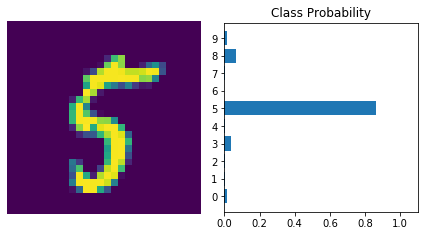

In [33]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.